In [1]:
import numpy as np
import joblib
import os, yaml, sys
import matplotlib.pyplot as plt
import numpy as np

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from pref_viewing.utils import plot_imgs
from alignment.utils import get_usual_transform
from parallel.parallel_funcs import print_wise
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform, get_transform_to_show
from experiments.utils import convert_to_save
from pref_viewing.utils import get_extreme_k
from datetime import datetime
import torch
from experiments.images_sampling import save_imgs_PCs, save_imgs_CCs, save_imgs_random, save_imgs_kmeans
from experiments.utils import project_onto_PCs, project_onto_CCs, map_on_savenames,get_k_imgs
import pandas as pd

[Tiziano-Causin.local:90223] shmem: mmap: an error occurred while determining whether or not /var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T//ompi.Tiziano-Causin.501/jf.0/2393309184/sm_segment.Tiziano-Causin.501.8ea70000.0 could be created.


In [18]:
model_name1, model_name2 = "resnet50", "vit_b_16"
layer_name1, layer_name2 = "layer3.4.relu_2", "encoder.ln"
test_model = "alexnet"
test_layer = "features.11"
n_imgs = 300
neurons_perc = 20

In [19]:
kmeans_path_aligned = f"{paths['results_path']}/sampling_comparisons/kmeans_CCs_{model_name1}+{model_name2}_{layer_name1}+{layer_name2}_test_{test_model}_{test_layer}_{n_imgs}_samples_{neurons_perc}perc_neurons.pkl"
samples_aligned = joblib.load(kmeans_path_aligned)

kmeans_path1 = f"{paths['results_path']}/sampling_comparisons/kmeans_PCs_{model_name1}_{layer_name1}_test_{test_model}_{test_layer}_{n_imgs}_samples_{neurons_perc}perc_neurons.pkl"
samples_mod1 = joblib.load(kmeans_path1)

kmeans_path2 = f"{paths['results_path']}/sampling_comparisons/kmeans_PCs_{model_name2}_{layer_name2}_test_{test_model}_{test_layer}_{n_imgs}_samples_{neurons_perc}perc_neurons.pkl"
samples_mod2 = joblib.load(kmeans_path2)

random_path_aligned = f"{paths['results_path']}/sampling_comparisons/random_CCs_{model_name1}+{model_name2}_{layer_name1}+{layer_name2}_test_{test_model}_{test_layer}_{n_imgs}_samples_{neurons_perc}perc_neurons.pkl"
random_samples = joblib.load(random_path_aligned)

In [20]:
print('\n aligned CCs var', samples_aligned['variance'], '\n model 1 PCs var', samples_mod1['variance'], '\n model 2 PCs var', samples_mod2['variance'], '\n random images var', random_samples['variance'])


 aligned CCs var 1.4415607 
 model 1 PCs var 1.9557532 
 model 2 PCs var 1.0830201 
 random images var 1.2376844


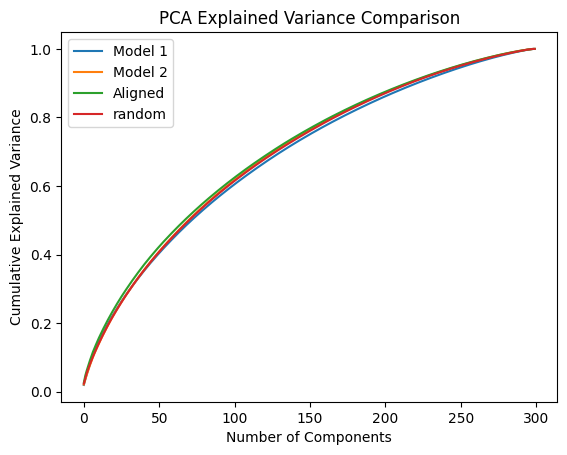

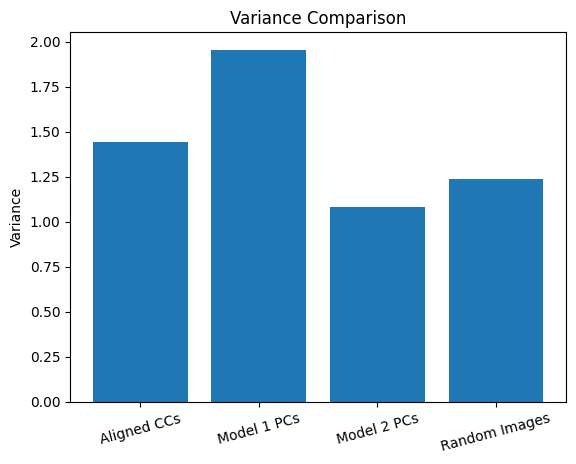

In [21]:


plt.plot(
    np.cumsum(samples_mod1['PCA'].explained_variance_ratio_), 
    label="Model 1"
)
plt.plot(
    np.cumsum(samples_mod2['PCA'].explained_variance_ratio_), 
    label="Model 2"
)
plt.plot(
    np.cumsum(samples_aligned['PCA'].explained_variance_ratio_), 
    label="Aligned"
)
plt.plot(
    np.cumsum(random_samples['PCA'].explained_variance_ratio_), 
    label="random"
)


# Add axis labels, title, and legend
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Comparison")
plt.legend()   # shows labels

plt.show()

plt.figure()
vars_to_plot = [
    samples_aligned['variance'],
    samples_mod1['variance'],
    samples_mod2['variance'],
    random_samples['variance']
]
labels = ["Aligned CCs", "Model 1 PCs", "Model 2 PCs", "Random Images"]

# Make bar plot
plt.bar(labels, vars_to_plot)

# Add axis labels and title
plt.ylabel("Variance")
plt.title("Variance Comparison")

# Rotate x-axis labels a bit if they overlap
plt.xticks(rotation=15)

plt.show()

In [36]:
np.random.seed(7)

# Grid
n = 400
x = np.linspace(-4, 4, n)
y = np.linspace(-4, 4, n)
X, Y = np.meshgrid(x, y)

# Multi-well Gaussian mixture
centers = np.array([
    [-2.2, -1.8],
    [ 2.0, -1.6],
    [-1.0,  2.1],
    [ 1.8,  1.7],
    [ 0.0,  0.0]
])
amps   = np.array([1.4, 1.0, 1.2, 0.9, 1.6])
widths = np.array([0.6, 0.8, 0.7, 0.9, 1.0])

Z = np.zeros_like(X)
for (cx, cy), a, w in zip(centers, amps, widths):
    Z += -a * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * w**2))  # wells (negative = low energy)

# Sinusoidal roughness + slight tilt to break symmetry
Z += 0.15*np.sin(3*X)*np.cos(2.5*Y) + 0.08*X - 0.06*Y

# Optional: normalize to a nice range
#Z = (Z - Z.min()) / (Z.max() - Z.min())
Z = -Z

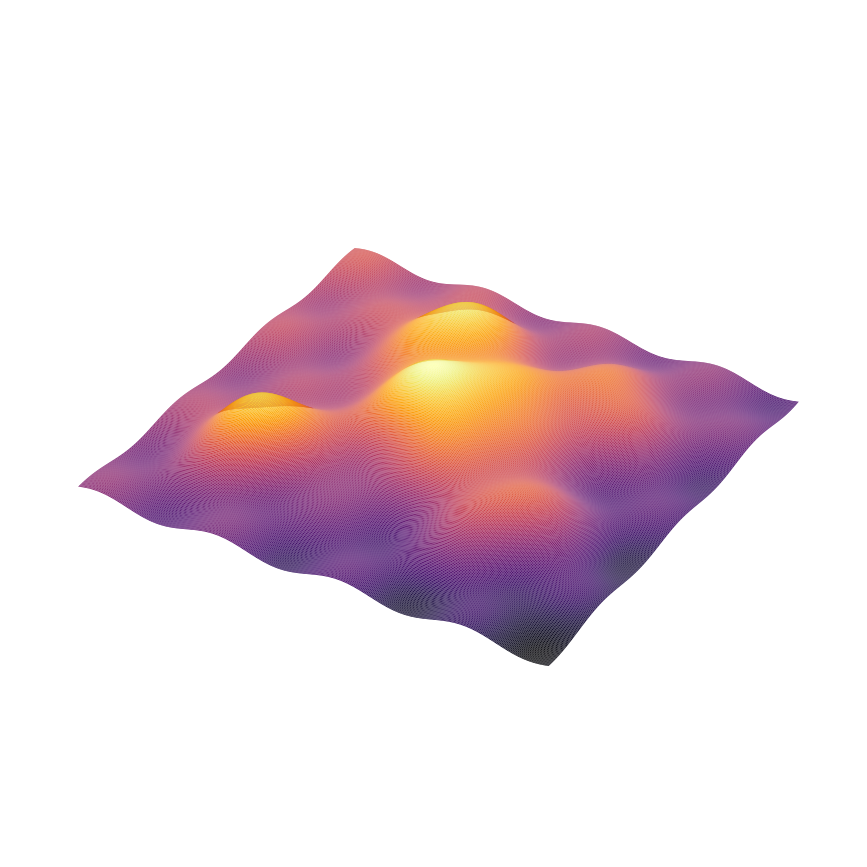

In [37]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (ensures 3D projection import)

fig = plt.figure(figsize=(8, 6), dpi=140)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, cmap='inferno')

# Hide axes & grid
ax.set_axis_off()
ax.grid(False)

# Optional: nicer aspect
ax.set_box_aspect((1, 1, 0.2))

plt.tight_layout(pad=0)
plt.show()

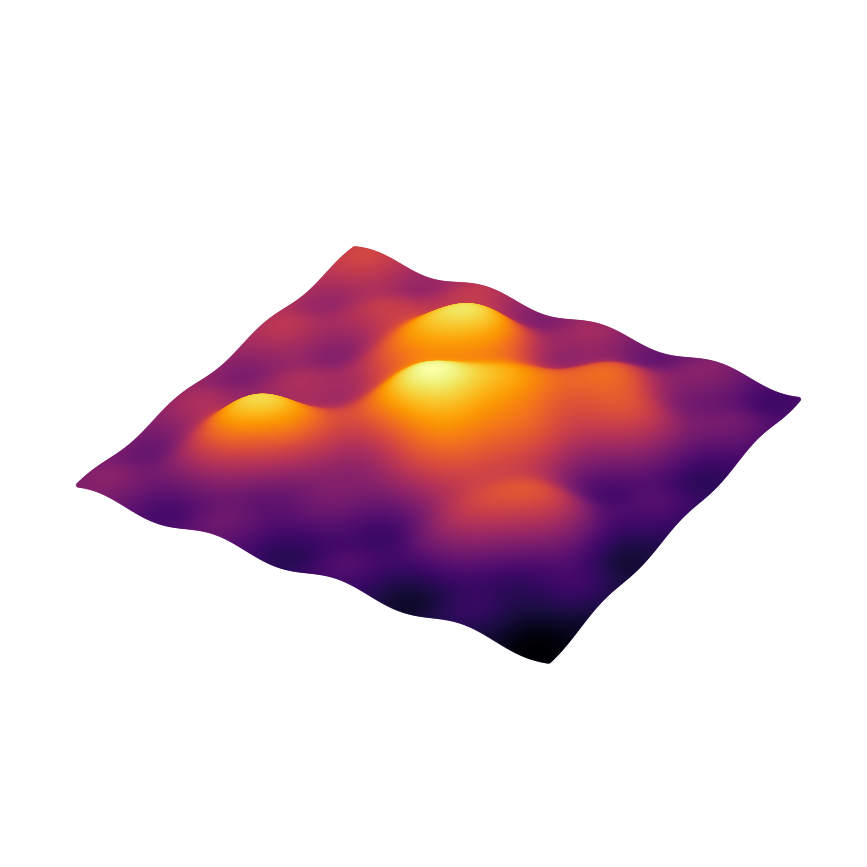

In [38]:
fig = plt.figure(figsize=(8, 6), dpi=140)
ax = fig.add_subplot(111, projection='3d')

# Scatter instead of surface
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(),
           c=Z.flatten(), cmap='inferno', s=2, alpha=0.8)

# Hide axes & grid
ax.set_axis_off()
ax.grid(False)

# Nicer aspect
ax.set_box_aspect((1, 1, 0.2))

plt.tight_layout(pad=0)
plt.show()